In [1]:
import skimage, os
from skimage import data, exposure, img_as_float, io , img_as_ubyte
import skimage.exposure as ex 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math

c:\Users\chris\miniconda3\envs\mypycv\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def plotImgAndHistEq(img, bins=256):
    
    ch = ex.equalize_hist(img, bins)
    #plot the equalized image next to original image
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(6, 6))

    #display original and equalized image
    ax[0, 0].imshow(img, cmap = 'gray')
    ax[0, 0].set_title('Low contrast image')
    ax[0, 1].imshow(ch, cmap = 'gray')
    ax[0, 1].set_title('Histogram equalization')

    #display histograms of the image with the desired number of bins
    h1 = ax[1, 0].hist(img.ravel(), bins)
    h2 = ax[1, 1].hist(ch.flatten(), bins)



# Histogram Equalization

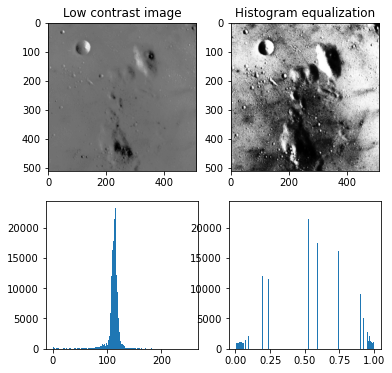

In [3]:
img = data.moon()
plotImgAndHistEq(img)

## Why it works?

As seen in the histogram lab before, the process of histogram stretching involves a gray level transformation (check the stretching function in the last lab, which mapped gray levels 5 - 9 (x-axis) to 2 - 14 (y-axis) ). 

Now, let's consider the cumulative histogram of that data. 

Cumulative what!? Before proceeding further, let us understand what cumulative sum is. Consider an array `[1, 3, 6, 7, 8]`, the cumulative sum simply accumulates the sum as we iterate through the array. So `1` stays `1`; then we encounter `3`, which becomes `1+3 = 4`; then we encounter `6`, which becomes `4+6 = 10`; then we encounter `7`, which becomes `10 + 7 = 17`, and so on...

Numpy has a function `cumsum` that does the job.

In [4]:
help(np.cumsum)

Help on function cumsum in module numpy:

cumsum(a, axis=None, dtype=None, out=None)
    Return the cumulative sum of the elements along a given axis.
    
    Parameters
    ----------
    a : array_like
        Input array.
    axis : int, optional
        Axis along which the cumulative sum is computed. The default
        (None) is to compute the cumsum over the flattened array.
    dtype : dtype, optional
        Type of the returned array and of the accumulator in which the
        elements are summed.  If `dtype` is not specified, it defaults
        to the dtype of `a`, unless `a` has an integer dtype with a
        precision less than that of the default platform integer.  In
        that case, the default platform integer is used.
    out : ndarray, optional
        Alternative output array in which to place the result. It must
        have the same shape and buffer length as the expected output
        but the type will be cast if necessary. See :ref:`ufuncs-output-type` for

In [5]:
a = np.array([1, 3, 6, 7, 8])
b = np.cumsum(a)
b

array([ 1,  4, 10, 17, 25])

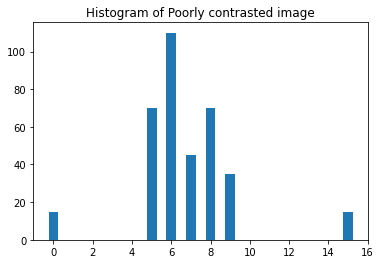

In [6]:
#Toy data with following frequencies (i.e. histogram)
freq = np.array([15, 0, 0, 0, 0, 70, 110, 45, 70, 35, 0, 0, 0, 0, 0, 15])
plt.bar(np.arange(16), freq, 0.5)
plt.title("Histogram of Poorly contrasted image")
plt.show()

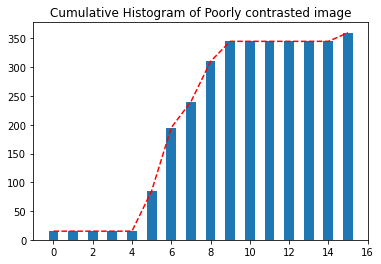

In [7]:
cumulative_histogram = np.cumsum(freq)
plt.plot(cumulative_histogram, 'r--')
plt.bar(np.arange(16), cumulative_histogram, 0.5)
plt.title("Cumulative Histogram of Poorly contrasted image")
plt.show()

The dashed line is simply joining the top of histogram bars. If we scale this so that the y-values are between 0-15, rather than 0-360, then we get the graph:

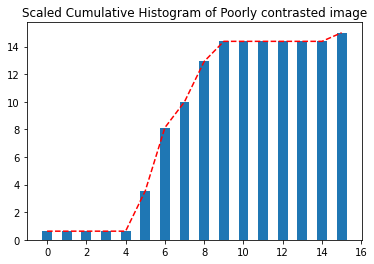

In [8]:
scaled_cumulative_histogram = (cumulative_histogram * 15)/360
plt.plot(scaled_cumulative_histogram, 'r--')
plt.bar(np.arange(16), scaled_cumulative_histogram, 0.5)
plt.title("Scaled Cumulative Histogram of Poorly contrasted image")
plt.show()

Now, note that this highly resembles the stretching function we previously defined! That is, just looking at the dashed line and interpreting this as a mapping, gray levels 5-9 are being roughly mapped to gray levels 2-14! It is giving a recipe for how histogram equalization works internally: that scaled version of cumulative histogram acts as a gray-level transformation. 

Let us apply histogram equalization on an image and check how the cumulative histogram changes. 

Note: histogram is also known as probability density function (pdf) and cumulative histogram is also known as the cumulative distributive function (cdf).

In [9]:
def plotImgHistCDF(im1, im2):
    '''
    Plots images, their histograms, overlaid with CDF (cumulative histogram)
    '''
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8, 5)) #figsize controls relative size of images

    ax[0, 0].imshow(im1, cmap=plt.cm.gray)
    ax[0, 1].hist(im1.flatten(),bins=256) 
    ax[1, 0].imshow(im2, cmap=plt.cm.gray)
    ax[1, 1].hist(im2.flatten(),bins=256)

    #Overlay the cdf on the histograms
    ax_cdf = ax[0, 1].twinx()
    im1_cdf, bins = ex.cumulative_distribution(im1, nbins=256)
    ax_cdf.plot(bins, im1_cdf, 'r')

    ax_cdf = ax[1, 1].twinx()
    im2_cdf, bins = ex.cumulative_distribution(im2, nbins=256)
    ax_cdf.plot(bins, im2_cdf, 'r')

    fig.tight_layout()
    plt.show()

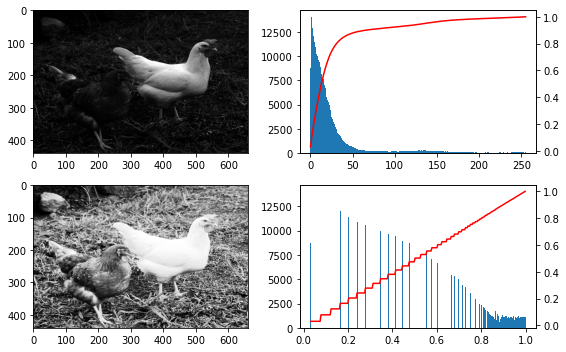

In [10]:
#Apply histogram equalization on the chickens image. 
#And overlay the cumulative histogram on top of the histogram

im = io.imread('chickens.png')
imh = ex.equalize_hist(im) 
plotImgHistCDF(im, imh)

# Recipe for Histogram Equalization
Following is an excerpt from the textbook "A Computational Introduction to Digital Image Processing" by Alasdair McAndrew:

![Recipe for histogram equalization](1600.jpeg)
![Recipe for histogram equalization continued](1601.jpeg)

In [11]:
#helper function
def normalizedSumOfAbsDifference(a, b):
    assert a.shape == b.shape
    return np.sum(np.abs(a-b))/a.size

In [12]:
#helper function
def plotImgAndHist(img, hist):
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))

    #display original and equalized image
    ax[0].imshow(img, cmap = 'gray')
    ax[0].set_title('Image')
    ax[1].bar(range(256), hist)
    ax[1].set_title('Histogram')
    
    fig.tight_layout()
    plt.show()


## Part 1: Compute the histogram by iterating through the image (10 points)
 - You should not use inbuilt functions for this part
 - You can assume 256 bins

[ 8758. 14018. 12919. 12062. 11448. 10923. 10552. 10265. 10017.  9614.
  9408.  8898.  8744.  8199.  7715.  7613.  7040.  6712.  6353.  5823.
  5472.  5287.  5001.  4439.  4210.  3749.  3537.  3218.  3006.  2745.
  2459.  2311.  2127.  1992.  1830.  1722.  1603.  1441.  1347.  1226.
  1177.  1075.   971.   955.   902.   867.   782.   709.   698.   647.
   605.   624.   553.   525.   471.   407.   450.   356.   379.   335.
   340.   342.   342.   287.   292.   276.   274.   243.   208.   241.
   254.   250.   204.   201.   196.   191.   197.   189.   206.   197.
   180.   180.   217.   197.   208.   198.   219.   190.   190.   178.
   181.   176.   169.   157.   175.   174.   202.   188.   178.   194.
   183.   211.   191.   167.   156.   177.   173.   194.   178.   181.
   189.   190.   189.   190.   178.   186.   188.   203.   193.   200.
   238.   193.   217.   232.   217.   229.   216.   271.   290.   297.
   273.   291.   315.   268.   290.   291.   301.   278.   233.   255.
   269

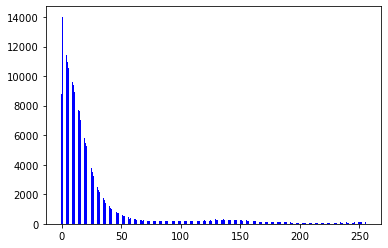

In [110]:
def myHistogram(img): #L=256 is the assumption
    '''
    Computes and returns the histogram of img. 
    Histogram is computed for 256 bins (i.e. each gray level gets its own bin) 
        - Does NOT use any inbuilt function TO compute histogram.
    '''
    #ensure img is of type uint8
    assert (img.dtype == 'uint8')

    imgHist = np.empty((256))
    for i in range(256):
            imgHist[i] = np.count_nonzero(img == i)
    return imgHist

    # YOUR CODE HERE
    #raise NotImplementedError()
img= io.imread('chickens.png')
print(myHistogram(img))
plt.bar(np.arange(256), myHistogram(img), 0.5, color='blue')
plt.show()


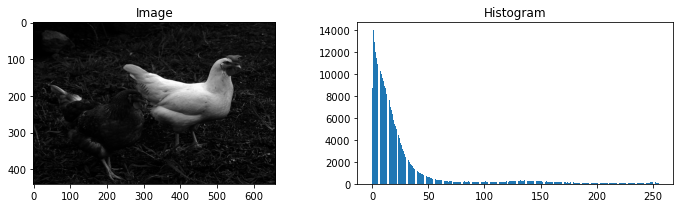

Success!


In [111]:
im = io.imread('chickens.png')
hist1 = myHistogram(im)
hist2, bins = np.histogram(im, bins=256)
plotImgAndHist(im, hist1)

assert(np.all(hist1 == hist2))
assert normalizedSumOfAbsDifference(hist1, hist2) == 0
print("Success!")

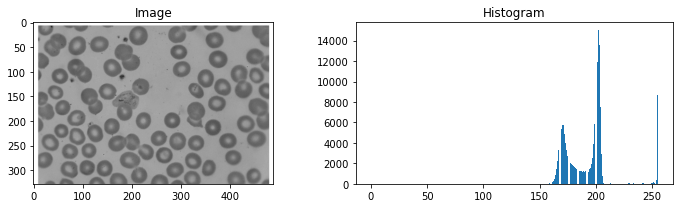

Success!


In [15]:
im = io.imread('blood.png')
hist1 = myHistogram(im)
hist2, bins = np.histogram(im, bins=256, range = (0, 255))
plotImgAndHist(im, hist1)

assert(np.all(hist1 == hist2))
assert normalizedSumOfAbsDifference(hist1, hist2) == 0
print("Success!")

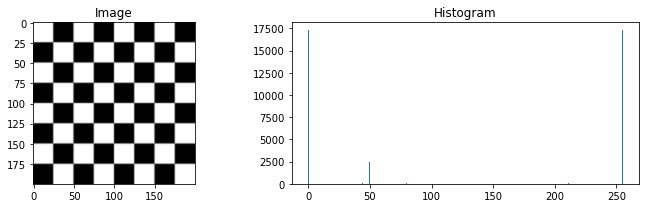

Success!


In [16]:
im = data.checkerboard()
hist1 = myHistogram(im)
hist2, bins = np.histogram(im, bins=256, range = (0, 255))
plotImgAndHist(im, hist1)

assert(np.all(hist1 == hist2))
assert normalizedSumOfAbsDifference(hist1, hist2) == 0
print("Success!")


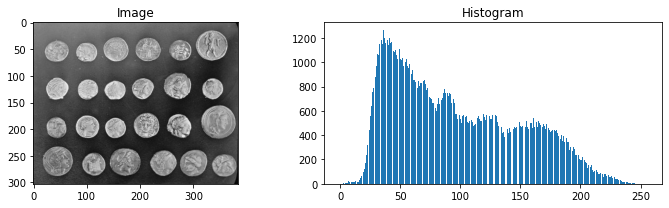

Success!


In [17]:
im = data.coins()
hist1 = myHistogram(im)
hist2, bins = np.histogram(im, bins=256, range = (0, 255))
plotImgAndHist(im, hist1)

assert(np.all(hist1 == hist2))
assert normalizedSumOfAbsDifference(hist1, hist2) == 0
print("Success!")

## Part 2a: Compute the \*mapping\* for histogram equalization using the method shown above (10 points)
 - You should not use inbuilt function for this part

In [18]:
from skimage.util import img_as_ubyte
def myHistEq(img): #L=256 is the assumption
    '''
    Computes and returns the gray level mapping based on the method described above. 
        - Calls myHistogram to compute the histogram.
        - Uses np.cumsum to compute cumulative sums.
    Output mapping must be of type uint8
    '''
    #ensure img is of type uint8
    assert (img.dtype == 'uint8')
    
    # YOUR CODE HERE
    hist = myHistogram(img)

    sum = np.sum(hist)

    imgEq = np.empty((256))

    count = 0

    for i in range(256):
            count = count + hist[i]
            imgEq[i] =  count

    test = img_as_ubyte(imgEq/sum)
    print(test)
    
    return test


[  8  20  31  42  52  62  71  80  89  97 105 113 121 128 135 142 148 154
 159 164 169 174 178 182 186 189 192 195 198 200 202 204 206 208 209 211
 212 214 215 216 217 218 219 220 220 221 222 222 223 224 224 225 225 226
 226 226 227 227 227 228 228 228 229 229 229 229 230 230 230 230 230 231
 231 231 231 231 231 232 232 232 232 232 233 233 233 233 233 233 234 234
 234 234 234 234 234 235 235 235 235 235 235 236 236 236 236 236 236 237
 237 237 237 237 237 238 238 238 238 238 238 239 239 239 239 239 240 240
 240 240 240 241 241 241 241 242 242 242 242 243 243 243 243 244 244 244
 244 245 245 245 245 245 246 246 246 246 246 247 247 247 247 247 247 248
 248 248 248 248 248 248 249 249 249 249 249 249 249 249 249 249 250 250
 250 250 250 250 250 250 250 250 250 251 251 251 251 251 251 251 251 251
 251 251 251 251 251 251 252 252 252 252 252 252 252 252 252 252 252 252
 252 252 252 252 252 252 253 253 253 253 253 253 253 253 253 253 253 253
 253 253 253 253 254 254 254 254 254 254 254 254 25

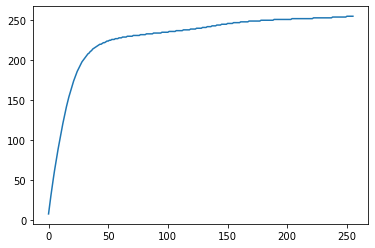

Success!


In [19]:
im = io.imread('chickens.png')
mapping = myHistEq(im)
print("Mapping info:", mapping.dtype, mapping.shape, mapping.min(), mapping.max())

plt.plot(mapping)
plt.show()

assert(mapping.dtype == 'uint8')
assert(mapping[7] == 80)
assert(np.sum(mapping) == 58243)
print("Success!")

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   1
   1   2   3   6   9  15  22  30  39  49  56  63  68  72  76  80  83  86
  88  91  93  96  98 100 102 104 106 108 110 112 113 115 118 120 123 127
 133 143 156 175 199 221 233 237 239 239 239 239 239 239 239 239 239 239
 239 239 239 239 239 239 239 239 239 239 239 239 239 239 239 239 239 239
 239 240 240 240 240 240 240 240 240 240 240 240 24

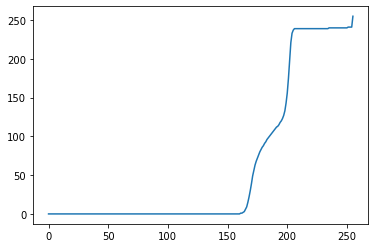

Success!


In [20]:
im = io.imread('blood.png')
mapping = myHistEq(im)
print("Mapping info:", mapping.dtype, mapping.shape, mapping.min(), mapping.max())

plt.plot(mapping)
plt.show()

assert(mapping[150] == 0)
assert(np.sum(mapping) == 16172)
print("Success!")

[110 110 110 110 110 110 110 110 110 110 110 110 110 110 110 110 110 110
 110 110 110 110 110 110 110 110 110 110 110 110 110 110 110 110 110 110
 110 110 110 110 110 110 110 110 111 111 111 111 111 111 127 127 127 127
 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127
 127 127 127 127 127 127 127 127 128 128 128 128 128 128 128 128 128 128
 128 128 128 128 128 128 128 128 128 128 128 128 128 128 128 128 128 128
 128 128 128 128 128 128 128 128 128 128 128 128 128 128 128 128 128 128
 128 128 128 128 128 128 128 128 128 128 128 128 128 128 128 128 128 128
 128 128 128 128 128 128 128 128 128 128 128 128 128 128 128 128 128 128
 128 128 128 128 128 128 128 128 128 128 128 128 128 128 128 128 128 128
 128 128 128 128 128 128 128 128 128 128 128 128 128 128 128 128 128 128
 128 128 128 128 128 128 128 144 144 144 144 144 144 145 145 145 145 145
 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145
 145 145 145 145 145 145 145 145 145 145 145 145 14

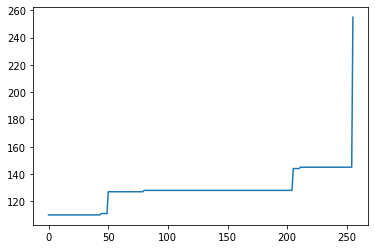

Success!


In [21]:
im = data.checkerboard()
mapping = myHistEq(im)
print("Mapping info:", mapping.dtype, mapping.shape, mapping.min(), mapping.max())
plt.plot(mapping)
plt.show()

assert(mapping[0] == 110)
assert(np.sum(mapping) == 32815)
print("Success!")

## Part 2b: Apply the mapping (obtained in Part 2a) to an image and compare to inbuilt implementation of histogram equalization. (10 points)

[  8  20  31  42  52  62  71  80  89  97 105 113 121 128 135 142 148 154
 159 164 169 174 178 182 186 189 192 195 198 200 202 204 206 208 209 211
 212 214 215 216 217 218 219 220 220 221 222 222 223 224 224 225 225 226
 226 226 227 227 227 228 228 228 229 229 229 229 230 230 230 230 230 231
 231 231 231 231 231 232 232 232 232 232 233 233 233 233 233 233 234 234
 234 234 234 234 234 235 235 235 235 235 235 236 236 236 236 236 236 237
 237 237 237 237 237 238 238 238 238 238 238 239 239 239 239 239 240 240
 240 240 240 241 241 241 241 242 242 242 242 243 243 243 243 244 244 244
 244 245 245 245 245 245 246 246 246 246 246 247 247 247 247 247 247 248
 248 248 248 248 248 248 249 249 249 249 249 249 249 249 249 249 250 250
 250 250 250 250 250 250 250 250 250 251 251 251 251 251 251 251 251 251
 251 251 251 251 251 251 252 252 252 252 252 252 252 252 252 252 252 252
 252 252 252 252 252 252 253 253 253 253 253 253 253 253 253 253 253 253
 253 253 253 253 254 254 254 254 254 254 254 254 25

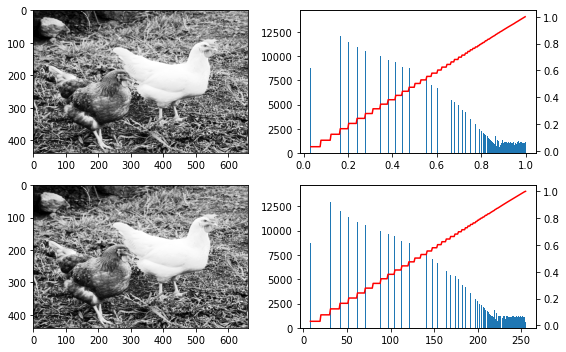

Success!


In [22]:
#our homegrown implementation
im = io.imread('chickens.png')
mapping = myHistEq(im)
im_mapped = mapping[im]
print("(Homegrown) Equalized Image Info", im_mapped.dtype, im_mapped.shape, im_mapped.min(), im_mapped.max())

#python inbuilt implementation
imh = ex.equalize_hist(im)

diff = 255*normalizedSumOfAbsDifference(imh, im_mapped/255)

print("(Inbuilt) Equalized Image Info", imh.dtype, imh.shape, imh.min(), imh.max())
print("Per pixel difference between homegrown and python implementation =", diff)
plotImgHistCDF(imh, im_mapped)
assert(math.isclose(diff, 0.20649330131))
print("Success!")

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   1
   1   2   3   6   9  15  22  30  39  49  56  63  68  72  76  80  83  86
  88  91  93  96  98 100 102 104 106 108 110 112 113 115 118 120 123 127
 133 143 156 175 199 221 233 237 239 239 239 239 239 239 239 239 239 239
 239 239 239 239 239 239 239 239 239 239 239 239 239 239 239 239 239 239
 239 240 240 240 240 240 240 240 240 240 240 240 24

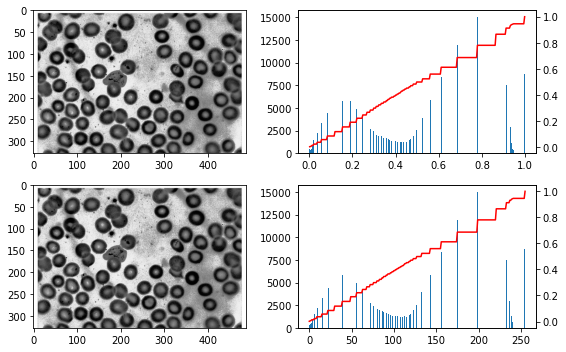

Success!


In [23]:
#our homegrown implementation
im = io.imread('blood.png')
mapping = myHistEq(im)
im_mapped = mapping[im]
print("(Homegrown) Equalized Image Info", im_mapped.dtype, im_mapped.shape, im_mapped.min(), im_mapped.max())

#python inbuilt implementation
imh = ex.equalize_hist(im)

print("(Inbuilt) Equalized Image Info", imh.dtype, imh.shape, imh.min(), imh.max())
diff = 255*normalizedSumOfAbsDifference(imh, im_mapped/255)
print("Per pixel difference between homegrown and python implementation =", diff)
plotImgHistCDF(imh, im_mapped)
assert(math.isclose(diff, 0.2472745604))
print("Success!")

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   1
   1   1   1   2   2   3   4   5   6   8  10  12  14  16  18  21  24  26
  29  32  34  37  39  42  44  47  49  52  54  56  59  61  63  66  68  70
  72  74  76  79  81  83  85  87  88  90  92  94  96  97  99 101 103 105
 107 108 110 111 113 114 116 117 118 120 121 123 124 126 128 129 131 133
 134 136 137 139 140 142 143 144 146 147 148 149 150 151 153 154 155 156
 157 158 160 161 162 163 164 165 166 167 169 170 171 172 173 175 176 177
 178 179 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196
 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 237 238 239 240 241 241 242 243 243 244 245 245 246 246
 247 247 248 248 249 249 249 250 250 250 251 251 251 252 252 252 252 252
 253 253 253 253 253 253 254 254 254 254 254 254 254 254 254 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 25

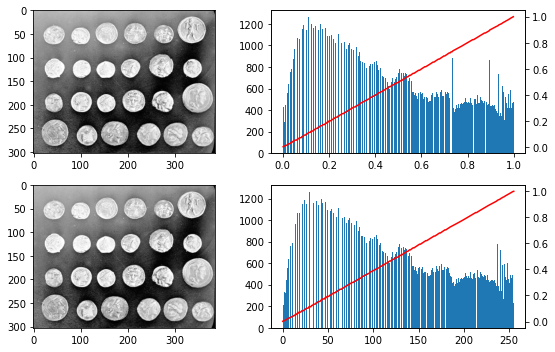

Success!


In [24]:
#our homegrown implementation
im = data.coins()
mapping = myHistEq(im)
im_mapped = mapping[im]
print("(Homegrown) Equalized Image Info", im_mapped.dtype, im_mapped.shape, im_mapped.min(), im_mapped.max())

#python inbuilt implementation
imh = ex.equalize_hist(im)

print("(Inbuilt) Equalized Image Info", imh.dtype, imh.shape, imh.min(), imh.max())
diff = 255*normalizedSumOfAbsDifference(imh, im_mapped/255)
print("Per pixel difference between homegrown and python implementation =", diff)
plotImgHistCDF(imh, im_mapped)
assert(math.isclose(diff, 0.2366664985))
print("Success!")

[  0   0   0   0   0   0   0   0   0   0   1   1   1   1   1   1   1   1
   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   2
   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2
   2   2   3   3   3   3   3   3   3   3   3   3   3   3   3   4   4   4
   4   4   4   4   5   5   5   5   6   6   6   6   7   7   7   8   8   9
   9  10  10  11  11  12  13  13  14  15  15  17  19  21  23  26  32  38
  49  61  76  94 113 134 151 174 190 201 213 222 231 236 241 244 245 247
 248 249 250 250 251 251 251 252 252 252 252 252 252 252 252 253 253 253
 253 253 253 253 253 253 253 253 253 253 254 254 254 254 254 254 254 254
 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254
 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 25

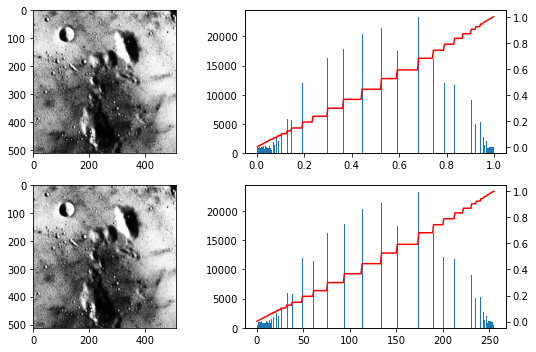

Success!


In [25]:
#our homegrown implementation
im = data.moon()
mapping = myHistEq(im)
im_mapped = mapping[im]
print("(Homegrown) Equalized Image Info", im_mapped.dtype, im_mapped.shape, im_mapped.min(), im_mapped.max())

#python inbuilt implementation
imh = ex.equalize_hist(im)

print("(Inbuilt) Equalized Image Info", imh.dtype, imh.shape, imh.min(), imh.max())
diff = 255*normalizedSumOfAbsDifference(imh, im_mapped/255)
print("Per pixel difference between homegrown and python implementation =", diff)
plotImgHistCDF(imh, im_mapped)
assert(math.isclose(diff, 0.2756264947))
print("Success!")

# Histogram Matching

From this [Reference](http://paulbourke.net/miscellaneous/equalisation/), check out the diagram showing the overview of the process of Histogram Matching:

![Histogram Matching](matchingdiagram.jpeg)

The main idea is to find a mapping for each gray level x<sub>i</sub> (0-255) to a gray level x<sub>j</sub> so that the respective cumulative distribution functions G(x<sub>i</sub>) and H(x<sub>j</sub>) match exactly. Note that, the range of cdf G and H is the same (between 0 and 1) - only then are they "comparable".

In continuous signal processing this matching would be perfect but in discrete case (such as with images), the cdf values G(x<sub>i</sub>) and H(x<sub>j</sub>) will only be "very close to each other". In other words, the goal would be, for each  x<sub>i</sub> (0-255), find a x<sub>j</sub> for which the cdfs G(x<sub>i</sub>) and H(x<sub>j</sub>) are closest to each other and not necessary identical. This is going to be implemented in the function below.

In [26]:
def findClosestIndex(val, inArray):
    '''
    Find and return the index ind in inArray for which val is closest to inArray[ind].
    Example: if inArray = np.array([1, 3, 6, 9, 10, 15]) and val = 5, 
             the closest values to 5 in inArray is 6 and 
             the corresponding index is 2. 
    '''
    
    # YOUR CODE HERE
    currIndex = 0
    currVal = 0
    currDiff = abs(val - inArray[0])
    diff = 0
    

    for idx, value in enumerate(inArray):
        diff = abs(val - value)

        if (currDiff > diff):
            currDiff = diff
            currIndex = idx
        


    return (currIndex)
print(findClosestIndex(24,np.array([1, 2,4,6,8,12,16,24,57]) ))





7


In [27]:
arr = np.array([1, 3, 6, 9, 10, 15])
assert(findClosestIndex(5, arr) == 2)
assert(findClosestIndex(12, arr) == 4)
assert(findClosestIndex(13, arr) == 5)
assert(findClosestIndex(0, arr) == 0)
print("Success! Calls to findClosestIndex pass.")

Success! Calls to findClosestIndex pass.


In [28]:
#Helper function to display input images and the matched image with respective histograms and cdfs
def plotHistMatchingCDF(im1, im2, immatched):
    '''
    Plots image, its histogram, overlaid with CDF (cumulative histogram)
    '''
    fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(8, 5)) #figsize controls relative size of images
    
    ax[0, 0].imshow(im1, cmap=plt.cm.gray, vmin=0, vmax =255)
    ax[0, 1].hist(im1.flatten(),bins=256) 
    ax[0, 1].set_xlim([0, 255])

    ax[1, 0].imshow(im2, cmap=plt.cm.gray, vmin=0, vmax =255)
    ax[1, 1].hist(im2.flatten(),bins=256)
    ax[1, 1].set_xlim([0, 255])

    ax[2, 0].imshow(immatched, cmap=plt.cm.gray, vmin=0, vmax =255)
    ax[2, 1].hist(immatched.flatten(),bins=256)
    ax[2, 1].set_xlim([0, 255])

    #Overlay the cdf on the histograms
    ax_cdf = ax[0, 1].twinx()
    im1_cdf, bins = ex.cumulative_distribution(im1, nbins=256)
    ax_cdf.plot(bins, im1_cdf, 'r')
    #print("im1 bins", bins.shape)

    ax_cdf = ax[1, 1].twinx()
    im2_cdf, bins = ex.cumulative_distribution(im2, nbins=256)
    ax_cdf.plot(bins, im2_cdf, 'r')
    #print("im2 bins", bins.shape)
    
    ax_cdf = ax[2, 1].twinx()
    immatched_cdf, bins = ex.cumulative_distribution(immatched, nbins=256)
    ax_cdf.plot(bins, immatched_cdf, 'r')
    #print("immatched bins", bins.shape)

    fig.tight_layout()
    plt.show()

## Part 3: Compute the \*mapping\* for histogram matching using the method shown above (20 points)
 - You should not use inbuilt function for this part

In [131]:

def myHistMatching(img1, img2): #assumes L=256 
    '''
    Computes and returns the gray level mapping that matches histogram of img1 to that of img2 (reference)
        - Calls myHistogram to compute the histogram.
        - Uses np.cumsum to compute cumulative sums.
        - Calls findClosestIndex to compute the mapping for each gray level
    Output mapping must be of type uint8
    '''
    
    #ensure imgs are of type uint8
    assert (img1.dtype == 'uint8')
    assert (img2.dtype == 'uint8')


    img1Hist = myHistogram(img1)
    img2Hist = myHistogram(img2)

    print(img1Hist)


    img1Sum = np.cumsum(img1Hist)
    img2Sum = np.cumsum(img2Hist)

    mapping = np.zeros((256))

    for idx, value in enumerate(img1Sum):
       mapping[idx] = findClosestIndex(value, img2Sum)
       #print('value: ' + str(value))
       #print('nearest value: ' + str(img2Sum[findClosestIndex(value, img2Sum)]) + ', idx: ' + str(findClosestIndex(value, img2Sum)))


    return mapping
    
    # YOUR CODE HERE



Image 1: uint8 (440, 660) 0 255
Image 2: uint8 (328, 488) 113 255
[ 8758. 14018. 12919. 12062. 11448. 10923. 10552. 10265. 10017.  9614.
  9408.  8898.  8744.  8199.  7715.  7613.  7040.  6712.  6353.  5823.
  5472.  5287.  5001.  4439.  4210.  3749.  3537.  3218.  3006.  2745.
  2459.  2311.  2127.  1992.  1830.  1722.  1603.  1441.  1347.  1226.
  1177.  1075.   971.   955.   902.   867.   782.   709.   698.   647.
   605.   624.   553.   525.   471.   407.   450.   356.   379.   335.
   340.   342.   342.   287.   292.   276.   274.   243.   208.   241.
   254.   250.   204.   201.   196.   191.   197.   189.   206.   197.
   180.   180.   217.   197.   208.   198.   219.   190.   190.   178.
   181.   176.   169.   157.   175.   174.   202.   188.   178.   194.
   183.   211.   191.   167.   156.   177.   173.   194.   178.   181.
   189.   190.   189.   190.   178.   186.   188.   203.   193.   200.
   238.   193.   217.   232.   217.   229.   216.   271.   290.   297.
   273.   2

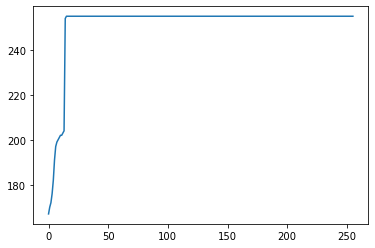

AssertionError: 

In [132]:
im1 = io.imread('chickens.png')
im2 = io.imread('blood.png')#data.checkerboard()#
print("Image 1:", im1.dtype, im1.shape, im1.min(), im1.max())
print("Image 2:", im2.dtype, im2.shape, im2.min(), im2.max())
mapping = myHistMatching(im1, im2)
plt.plot(mapping)
plt.show()

assert(mapping.dtype == 'uint8')
assert(mapping[0] == 166)
assert(np.sum(mapping) == 58523)

print("Success!")

Matched image -homegrown-: (440, 660) float64 167.0 255.0
Matched image -inbuilt-: (440, 660) float64 165.52806190896652 255.0
Average difference between homegrown and inbuilt implementation= 29.062804553134086


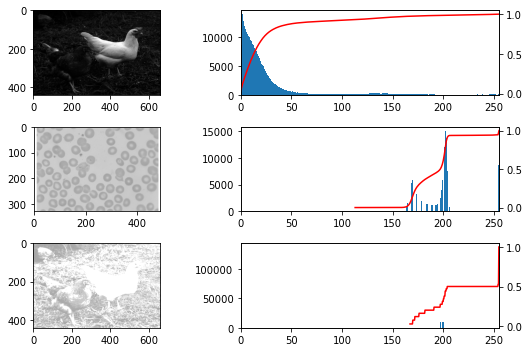

AssertionError: 

In [133]:
matchedImage1 = mapping[im1]
print("Matched image -homegrown-:", matchedImage1.shape, matchedImage1.dtype, matchedImage1.min(), matchedImage1.max())

matchedImage2 = ex.match_histograms(im1, im2)
print("Matched image -inbuilt-:", matchedImage2.shape, matchedImage2.dtype, matchedImage2.min(), matchedImage2.max())

diff = normalizedSumOfAbsDifference(matchedImage1, matchedImage2)
print("Average difference between homegrown and inbuilt implementation=", diff)

plotHistMatchingCDF(im1, im2, matchedImage1)
assert(math.isclose(diff, 0.2379903103))
print("Success!")

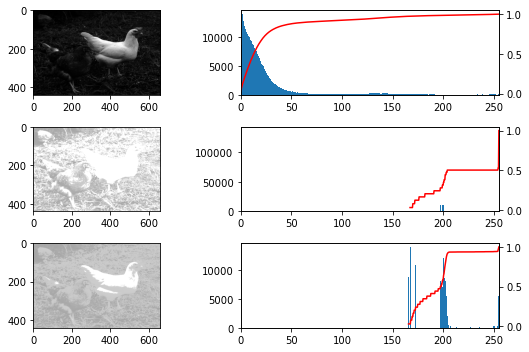

In [134]:
#Compare the two matched images: homegrown vs in-built
plotHistMatchingCDF(im1, matchedImage1, matchedImage2)

In [90]:
im1 = io.imread('chickens.png')
im2 = data.coins()
print("Image 1:", im1.dtype, im1.shape, im1.min(), im1.max())
print("Image 2:", im2.dtype, im2.shape, im2.min(), im2.max())
mapping = myHistMatching(im1, im2)

matchedImage1 = mapping[im1]
matchedImage2 = ex.match_histograms(im1, im2)

print("Matched image -homegrown-:", matchedImage1.dtype, matchedImage1.min(), matchedImage1.max())
print("Matched image -inbuilt-:", matchedImage2.dtype, matchedImage2.min(), matchedImage2.max())

diff = normalizedSumOfAbsDifference(matchedImage1, matchedImage2)
print("Average difference between homegrown and python implementation=", diff)

plotHistMatchingCDF(im1, matchedImage1, matchedImage2)
#plotHistMatchingCDF(im1, im2, matchedImage1)
assert(math.isclose(diff, 0.2476242432))
print("Success!")

Image 1: uint8 (440, 660) 0 255
Image 2: uint8 (303, 384) 1 252
100357.0
[[ 45.16013073  41.06964894  41.06964894 ...  71.30549839  71.30549839
   66.78227756]
 [ 45.16013073  41.06964894  41.06964894 ...  62.09004974  62.09004974
   71.30549839]
 [ 49.24860469  45.16013073  41.06964894 ...  71.30549839  86.26557391
   90.41657342]
 ...
 [122.26837297 109.68511811  90.41657342 ...  62.09004974  76.18826994
   71.30549839]
 [142.22378122  57.59932077  26.7777651  ...  36.93774059  45.16013073
   45.16013073]
 [ 71.30549839  62.09004974  66.78227756 ...  57.59932077  62.09004974
   62.09004974]]
Matched image -homegrown-: float64 26.777765096856005 252.0
Matched image -inbuilt-: float64 26.777765096856005 252.0


AssertionError: 

In [ ]:
im1 = io.imread('chickens.png')
im2 = data.checkerboard()#io.imread('eagle.png')#
print("Image 1:", im1.dtype, im1.shape, im1.min(), im1.max())
print("Image 2:", im2.dtype, im2.shape, im2.min(), im2.max())
mapping = myHistMatching(im1, im2)
matchedImage1 = mapping[im1]
matchedImage2 = ex.match_histograms(im1, im2)

print("Matched image -homegrown-:", matchedImage1.dtype, matchedImage1.min(), matchedImage1.max())
print("Matched image -inbuilt-:", matchedImage2.dtype, matchedImage2.min(), matchedImage2.max())

diff = normalizedSumOfAbsDifference(matchedImage1, matchedImage2)
print("Average difference between homegrown and python implementation=", diff)

plotHistMatchingCDF(im1, matchedImage1, matchedImage2)
#plotHistMatchingCDF(im1, im2, matchedImage1)
assert(math.isclose(diff, 5.806329865))
print("Success!")

Image 1: uint8 (328, 488) 113 255
Image 2: uint8 (303, 384) 1 252
[0.000e+00 1.000e+00 2.000e+00 7.000e+00 1.000e+01 7.000e+00 1.000e+01
 2.700e+01 1.600e+01 1.400e+01 1.700e+01 1.300e+01 1.300e+01 1.900e+01
 1.300e+01 1.800e+01 2.900e+01 4.800e+01 6.800e+01 9.600e+01 1.200e+02
 1.730e+02 2.390e+02 3.190e+02 4.460e+02 5.560e+02 6.400e+02 7.560e+02
 7.860e+02 8.770e+02 9.650e+02 1.069e+03 1.061e+03 1.149e+03 1.186e+03
 1.147e+03 1.264e+03 1.195e+03 1.160e+03 1.179e+03 1.142e+03 1.197e+03
 1.154e+03 1.163e+03 1.089e+03 1.085e+03 1.100e+03 1.061e+03 1.026e+03
 1.110e+03 1.028e+03 1.022e+03 1.031e+03 9.700e+02 1.003e+03 1.023e+03
 9.710e+02 9.560e+02 9.880e+02 9.010e+02 9.380e+02 8.530e+02 8.500e+02
 8.390e+02 7.890e+02 8.460e+02 8.050e+02 8.290e+02 8.280e+02 8.470e+02
 8.570e+02 8.220e+02 7.690e+02 7.900e+02 7.160e+02 7.050e+02 6.950e+02
 6.640e+02 6.640e+02 6.210e+02 6.000e+02 6.580e+02 7.020e+02 6.580e+02
 6.860e+02 7.070e+02 7.460e+02 7.810e+02 7.430e+02 7.470e+02 7.180e+02
 7.430e+02 

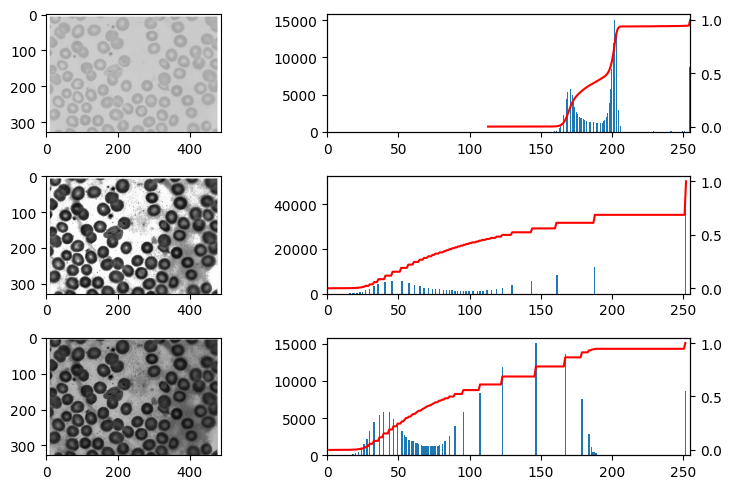

AssertionError: 

In [242]:
im1 = io.imread('blood.png')
im2 = data.coins()#io.imread('eagle.png')#
print("Image 1:", im1.dtype, im1.shape, im1.min(), im1.max())
print("Image 2:", im2.dtype, im2.shape, im2.min(), im2.max())
mapping = myHistMatching(im1, im2)
matchedImage1 = mapping[im1]
matchedImage2 = ex.match_histograms(im1, im2)

print("Matched image -homegrown-:", matchedImage1.dtype, matchedImage1.min(), matchedImage1.max())
print("Matched image -inbuilt-:", matchedImage2.dtype, matchedImage2.min(), matchedImage2.max())

diff = normalizedSumOfAbsDifference(matchedImage1, matchedImage2)
print("Average difference between homegrown and python implementation=", diff)

plotHistMatchingCDF(im1, matchedImage1, matchedImage2)
#plotHistMatchingCDF(im1, im2, matchedImage1)
assert(math.isclose(diff, 0.2362946726))
print("Success!")